## Setup

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os
from tqdm import tqdm
import __main__

from cell_inference.config import paths, params
from cell_inference.cells.simulation import SIMULATION_CLASS
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.random_parameter_generator import generate_parameters_from_config
from cell_inference.utils.transform.geometry_transformation import cart2pol
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
h.tstop = params.TSTOP
h.dt = params.DT
h.steps_per_ms = 1/h.dt

geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')

## Set up configuration

#### Set batch

In [2]:
batch_id = 5
number_cells = 2  # number of neurons
number_locs = 2  # number of locations for each neuron

if not hasattr(__main__, 'get_ipython'):
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('batch_id', type=int, nargs='?', default=None, help="Batch ID", metavar='Batch ID')
    parser.add_argument('-c', type=int, nargs='?', default=number_cells, help="Number of cells", metavar='# Cells')
    parser.add_argument('-l', type=int, nargs='?', default=number_locs, help="Number of locations", metavar='# Locations')
    args = parser.parse_args()
    batch_id = args.batch_id
    number_cells = args.c
    number_locs = args.l

In [3]:
if batch_id is None:
    batch_id = 0
    batch_suf = ''
else:
    batch_suf = '_%d' % batch_id

#### Trial configurations

In [4]:
TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc5_restrict_h'
number_samples = number_cells * number_locs  # number of samples
rand_seed = 0

inference_list = ['y', 'd', 'theta', 'h', 'phi', 'l_t', 'lr_pt', 'r_t', 'rr_dt']  # can use d, theta instead of x, z to represent location
randomized_list = ['alpha']  # randomized parameters not to inferred
randomized_list += inference_list
# parameters not in the two lists above are fixed at default.

#### Simulation configurations

In [5]:
loc_param_list = ['x', 'y', 'z', 'alpha', 'h', 'phi']
geo_param_list = ['l_t', 'lr_pt', 'r_t', 'rr_dt']

loc_param_default = {'x': 0., 'y': 0., 'z': 50., 
                     'alpha': np.pi/4, 'h': 1., 'phi': 0.}
loc_param_default['d'], loc_param_default['theta'] = cart2pol(loc_param_default['x'], loc_param_default['z'])
geo_param_default = {'l_t': 950., 'lr_pt': 0.142, 'r_t': 1.0, 'rr_dt': 0.59}

loc_param_range = {'x': (-50, 50), 'y': (-750., 750.), 'z': (50., 200.), 
                   'alpha': (0, np.pi), 'h': (.7071, 1.) ,'phi': (-np.pi, np.pi), 
                   'd': (50., 200.), 'theta': (-np.pi/3, np.pi/3)}
geo_param_range = {'l_t': (100., 1200.), 'lr_pt': (0.02, 0.35), 'r_t': (0.4, 1.5), 'rr_dt': (0.4, 0.8)}

loc_param_dist = {'x': 'unif', 'y': 'unif', 'z': 'unif', 
                  'alpha': 'unif', 'h': 'unif','phi': 'unif', 'd': 'unif', 'theta': 'norm'}
geo_param_dist = {'l_t': 'unif', 'lr_pt': 'unif', 'r_t': 'unif', 'rr_dt': 'unif'}

n_sigma = 3.  # range parameter for normal type distributions

#### Synapse parameters

In [6]:
simulation_class = 'Simulation_stochastic' # 'Simulation_stochastic'
syn_params = {}
if simulation_class == 'Simulation_stochastic':
    h.tstop = 2000.
    tstart = 200.
    point_conductance_division = {'soma': [0], 'perisomatic': [1,4], 'basal': [2,3], 'apical': [7,8,9,10]}
    dens_params = {
        'soma': {'g_e0': 0., 'g_i0': 24e-5, 'std_e': 1., 'std_i': 1.5},
        'perisomatic': {'g_e0': 0., 'g_i0': 6e-5, 'std_e': 1., 'std_i': 1.5},
        'basal': {'g_e0': 1.9e-5, 'g_i0': 2.45e-5, 'std_e': 3.4, 'std_i': 2.},
        'apical': {'g_e0': 1.35e-5, 'g_i0': 1e-5, 'std_e': 4., 'std_i': 3.}
    }
    cnst_params = {'tau_e': 2., 'tau_i': 10., 'tau_n': 40.}
    has_nmda = True
    syn_params = {
        'tstart': tstart, 'point_conductance_division': point_conductance_division,
        'dens_params': dens_params, 'cnst_params': cnst_params, 'has_nmda': has_nmda
    }
else:
    stim_param = params.STIM_PARAM
    # Fixed gmax, not using gmax mapping file
    gmax_mapping = None
    gmax = [[0.005, 0.05]]
    syn_sec = [0, 8]
    syn_loc = .5
    syn_params = {
        'stim_param': stim_param, 'gmax_mapping': gmax_mapping,
        'gmax': gmax, 'syn_sec': syn_sec, 'syn_loc': syn_loc
    }

#### Fixed biophysical parameters

In [7]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5_stochastic.json' # active dendrites
# filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5.json' # higer gNa dendrites
with open(filepath) as f:
    full_biophys = json.load(f)

# common parameters
biophys_param = [2.04, 0.0213 * 0.6, 0.0213 * 0.6, 0.693 * 2, 0.000261 * 2, 100., 100., 0.0000525, 0.000555, 0.0187,
                np.nan, np.nan, np.nan, np.nan, .6, 2.4]
biophys_comm = {}

# whether use parameter interpreter
interpret_params = True
interpret_type = 3

### Create configuration dictionary

In [8]:
config_dict = { 
    'Trial_Parameters': {
        'number_cells': number_cells, 'number_locs': number_locs, 
        'number_samples': number_samples, 'rand_seed': rand_seed, 'batch_id': batch_id,
        'inference_list': inference_list, 'randomized_list': randomized_list
    }, 
    'Simulation_Parameters': {
        'loc_param_list': loc_param_list, 'geo_param_list': geo_param_list, 
        'loc_param_default': loc_param_default, 'geo_param_default': geo_param_default, 
        'loc_param_range': loc_param_range, 'geo_param_range': geo_param_range, 
        'loc_param_dist': loc_param_dist, 'geo_param_dist': geo_param_dist,
        'n_sigma': n_sigma, 'simulation_class': simulation_class, 'tstop': h.tstop,
        'full_biophys': filepath, 'biophys_param': biophys_param, 'biophys_comm': biophys_comm,
        'interpret_params': interpret_params, 'interpret_type': interpret_type
    }
}
config_dict['Simulation_Parameters'].update(syn_params)

## Generate random samples

In [9]:
labels, rand_param, loc_param, geo_param = generate_parameters_from_config(config_dict)

print(loc_param.shape)
print(geo_param.shape)
print(labels.shape)

(2, 2, 6)
(2, 4)
(4, 9)


## Create simulation and run

In [10]:
import time
import datetime
timer_start = time.time()

sim = SIMULATION_CLASS[simulation_class](
    cell_type = CellTypes.REDUCED_ORDER,
    ncell = number_cells,
    geometry = geo_standard,
    electrodes = params.ELECTRODE_POSITION,
    loc_param = loc_param,
    geo_param = geo_param,
    biophys = biophys_param,
    full_biophys = full_biophys,
    biophys_comm = biophys_comm,
    interpret_params = interpret_params,
    interpret_type = interpret_type,
    min_distance = params.MIN_DISTANCE,
    record_soma_v = False,
    spike_threshold = params.SPIKE_THRESHOLD,
    randseed = rand_seed + batch_id,
    **syn_params
)

sim.run_neuron_sim()

print('Simulation run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))

Simulation run time: 0:01:30.719454


## Get LFPs
#### Save what

In [11]:
save_lfp = True
save_stats = True
cell_idx = 0 # for verification

#### Remove cells with invalid firing pattern

In [12]:
if simulation_class == 'Simulation_stochastic':
    spk_windows, nspk = sim.get_spk_windows('all')
    valid = nspk > 1
    firing_rate = 1000. * nspk / (h.tstop - sim.tstart * h.dt)
else:
    nspk, _ = sim.get_spike_number('all')
    valid = nspk == 1

invalid = np.nonzero(~valid)[0]
valid = np.nonzero(valid)[0]
invalid_nspk = nspk[invalid]
for n in np.unique(invalid_nspk):
    print('%d cells fire %d times.' % (np.count_nonzero(invalid_nspk==n), n))

In [13]:
invalid_params = {}
invalid_params['geo_param'] = geo_param[invalid, :]
invalid_params['gmax'] = None if sim.gmax is None else sim.gmax[invalid]

invalid_samples = (number_locs * invalid[:, np.newaxis] + np.arange(number_locs)).ravel()
number_samples -= invalid_samples.size
labels = np.delete(labels, invalid_samples, axis=0)
rand_param = np.delete(rand_param, invalid_samples, axis=0)
gmax = None if sim.gmax is None else np.repeat(sim.gmax[valid], number_locs)

additional_save = {}
if simulation_class == 'Simulation_stochastic':
    additional_save['firing_rate'] = firing_rate[valid]

#### Get LFP for valid cells

In [14]:
if simulation_class == 'Simulation_stochastic':
    lfp_locs = lambda i: sim.get_eaps_by_windows(index=valid[i], spk_windows=spk_windows[valid[i]], multiple_position=True)
else:
    timer_start = time.time()
    start_idx = int(max(np.ceil(sim.stim.start / h.dt) - params.PK_TR_IDX_IN_WINDOW, 0)) # ignore signal before
    lfp = sim.get_lfp(index=valid, t_index=slice(start_idx, None), multiple_position=True) # (cells x locs x channels x time)
    lfp = np.moveaxis(lfp, -2, -1) # -> (cells x locs x time x channels)
    print('LFP run time: ' + str(datetime.timedelta(seconds=time.time() - timer_start)))
    lfp_locs = lambda i: lfp[i]

#### Process LFP

In [15]:
pad_spike_window = True
bad_cases = tuple(range(-1,3)) if pad_spike_window else tuple(range(3))
if 'y' in inference_list:
    y_idx = inference_list.index('y')
    ycoord = lambda i: labels[i, y_idx]
else:
    ycoord = lambda i: None

bad_indices = {bad: [] for bad in bad_cases}
lfp_list = []
yshift = []
summ_stats = []
good_count = 0
coords = None

i = 0 # in range(number_samples)
for j in tqdm(range(valid.size)):
    for lfp_loc in lfp_locs(j):
        bad, g_lfp, _, g_coords, _, ys, ss = process_lfp(
            lfp_loc, dt=None, pad_spike_window=pad_spike_window, ycoord=ycoord(i),
            gauss_filt=True, calc_summ_stats=save_stats, additional_stats=1, err_msg=True
        )
        bad_indices[bad].append(i)
        if bad<=0:
            if good_count == cell_idx:
                coords = g_coords
            good_count += 1
            lfp_list.append(g_lfp)
            yshift.append(ys)
            if save_stats:
                summ_stats.append(ss)
        i += 1

t = sim.t()[:params.WINDOW_SIZE]
windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
yshift = np.array(yshift)
summ_stats = np.array(summ_stats)

good_indices = np.sort([i for bad, indices in bad_indices.items() if bad<=0 for i in indices])
print('%d good samples out of %d samples.' % (good_count, number_samples))
for bad, indices in bad_indices.items():
    print('Bad case %d bad: %d samples.' % (bad, len(indices)))

100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s]

4 good samples out of 4 samples.
Bad case -1 bad: 0 samples.
Bad case 0 bad: 4 samples.
Bad case 1 bad: 0 samples.
Bad case 2 bad: 0 samples.


## Save configurations and simulation data

In [16]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp' + batch_suf)  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats' + batch_suf)  # summary statistics
MEM_VOLT_PATH = os.path.join(TRIAL_PATH, 'mem_volt' + batch_suf)  # membrane voltage and spike times

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    print("The new data directory is created!")

if not os.path.exists(TRIAL_PATH):
    os.makedirs(TRIAL_PATH)
    print("The new trial directory is created!")

The new trial directory is created!


In [17]:
if save_lfp:
    np.savez(LFP_PATH, t=t, x=windowed_lfp, y=labels, ys=yshift, rand_param=rand_param, gmax=gmax,
             bad_indices=bad_indices, good_indices=good_indices, invalid_params=invalid_params, **additional_save)
if save_stats:
    np.savez(STATS_PATH, x=summ_stats, y=labels[good_indices], ys=yshift,
             rand_param=rand_param[good_indices], gmax=None if gmax is None else gmax[good_indices])
# np.savez(MEM_VOLT_PATH, v=mem_volt, spk=tspk)
if batch_id == 0:
    with open(CONFIG_PATH, 'w') as fout:
        json.dump(config_dict, fout, indent=2)

## Verify LFPs
We hand compare the LFP plots generated by our data

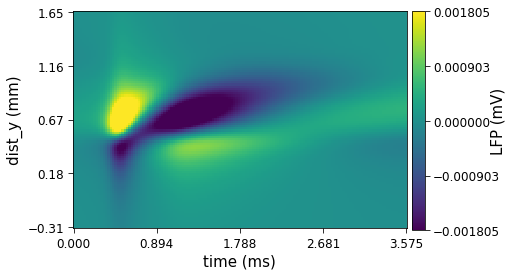

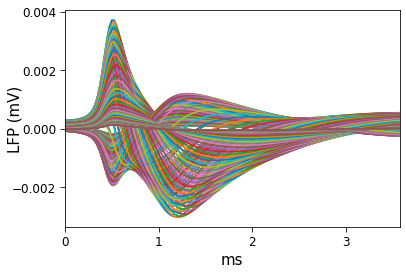

In [18]:
%matplotlib inline

ix = 1
x_dist = np.unique(coords[:,0])
e_idx = coords[:,0]==x_dist[ix]

_ = plot_lfp_heatmap(t, coords[e_idx, 1], windowed_lfp[cell_idx][:, e_idx], vlim='auto',
                     fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5)

_ = plot_lfp_traces(t, windowed_lfp[cell_idx], fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5)

In [19]:
# import importlib, sys
# importlib.reload(sys.modules['cell_inference.utils.feature_extractors.SummaryStats2D'])
# from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp, filt_b, filt_a, get_t_window
# from cell_inference.utils import spike_window
# from scipy import signal

# bad_idx = np.array([i for bad, indices in bad_indices.items() if bad>0 for i in indices])
# bad_i = bad_idx[0] # check bad case
# bad_j, bad_k = np.unravel_index(bad_i, (number_samples//number_locs, number_locs))
# eaps = lfp_locs(bad_j)[bad_k]
# _, _, _, _, _, _, _, bad_full = process_lfp(
#     eaps, dt=None, ycoord=ycoord(bad_i), gauss_filt=True,
#     calc_summ_stats=save_stats, additional_stats=1, err_msg=True, err_full=True)
# bad_full = np.nonzero(bad_full)[0]
# print(bad_full)

In [20]:
# filtered_lfp = signal.lfilter(filt_b, filt_a, eaps, axis=1)
# try:
#     spike_window.get_spike_window(filtered_lfp[bad_full[0]], win_size=params.WINDOW_SIZE, align_at=params.PK_TR_IDX_IN_WINDOW)
# except ValueError as e:
#     print(e)

# tt = h.dt * np.arange(eaps.shape[1])
# coord = params.ELECTRODE_POSITION
# ee_idx = coord[:, 0]==x_dist[ix]
# for eap in filtered_lfp[bad_full]:
#     plt.figure(figsize=(8, 5))
#     _ = plot_lfp_heatmap(t=tt, elec_d=coord[ee_idx, 1], lfp=1000 * eap[:, ee_idx],
#                          fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5,
#                          vlim='auto', colorbar_label='EAP (μV)', axes=plt.gca())
#     plt.ylabel('y distance (mm)')
#     plt.figure(figsize=(8, 5))
#     _ = plot_lfp_traces(tt, 1000 * eap[:, ee_idx], #electrodes=coords[e_idx, :],
#                     fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5, axes=plt.gca())
#     plt.gca().set_ylabel('EAP (μV)')
#     plt.show()

In [21]:
# _, pad_lfp = get_t_window(eaps[bad_full[0]], pad_spike_window=True, err_msg=True)
# ttt = h.dt * np.arange(pad_lfp.shape[0])
# plt.figure(figsize=(8, 5))
# _ = plot_lfp_heatmap(t=ttt, elec_d=coord[ee_idx, 1], lfp=1000 * pad_lfp[:, ee_idx],
#                      fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5,
#                      vlim='auto', colorbar_label='EAP (μV)', axes=plt.gca())
# plt.ylabel('y distance (mm)')
# plt.figure(figsize=(8, 5))
# _ = plot_lfp_traces(ttt, 1000 * pad_lfp[:, ee_idx], #electrodes=coords[e_idx, :],
#                 fontsize=15, labelpad=-10, ticksize=12, tick_length=5, nbins=5, axes=plt.gca())
# plt.gca().set_ylabel('EAP (μV)')
# plt.show()